In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import data, color
from skimage.transform import resize

In [2]:
# Function: Load and preprocess images
def load_images(n_samples=10, img_size=(32, 32)):
    images = [resize(color.rgb2gray(data.astronaut()), img_size) for _ in range(n_samples)]
    X = np.array(images).reshape(n_samples, -1)  # Flatten images
    return X

# Function: Initialize dictionary randomly
def initialize_dictionary(X, n_components):
    np.random.seed(42)
    indices = np.random.choice(X.shape[0], n_components, replace=False)
    return X[indices].T  # Shape: (image_pixels, n_components)

# Function: Orthogonal Matching Pursuit (OMP) for Sparse Coding
def omp(X, D, sparsity=5):
    n_samples, n_features = X.shape
    n_components = D.shape[1]
    sparse_codes = np.zeros((n_samples, n_components))
    
    for i in range(n_samples):
        residual = X[i]
        indices = []
        
        for _ in range(sparsity):
            projections = np.dot(D.T, residual)
            best_index = np.argmax(np.abs(projections))
            indices.append(best_index)
            
            # Solve least squares for selected atoms
            selected_atoms = D[:, indices]
            sparse_coeffs, _, _, _ = np.linalg.lstsq(selected_atoms, X[i], rcond=None)
            
            # Update residual
            residual = X[i] - np.dot(selected_atoms, sparse_coeffs)
        
        sparse_codes[i, indices] = sparse_coeffs
    return sparse_codes

# Function: K-SVD Dictionary Update
def k_svd(X, D, sparse_codes, n_iter=10):
    for _ in range(n_iter):
        for j in range(D.shape[1]):
            # Find data points using this dictionary atom
            nonzero_indices = np.where(sparse_codes[:, j] != 0)[0]
            if len(nonzero_indices) == 0:
                continue
            
            # Compute error for current dictionary atom
            error_matrix = X - np.dot(sparse_codes, D.T)
            error_matrix += np.outer(sparse_codes[:, j], D[:, j])
            
            # Update dictionary atom using SVD
            U, S, Vt = np.linalg.svd(error_matrix[nonzero_indices, :], full_matrices=False)

            # Ensure shape consistency for dictionary update
            if U.shape[0] == D.shape[0]:
                D[:, j] = U[:, 0]
            else:
                D[:, j] = np.pad(U[:, 0], (0, D.shape[0] - U.shape[0]), mode='constant')

            # Fix sparse_codes assignment
            sparse_codes[nonzero_indices, j] = S[0] * Vt[0, :len(nonzero_indices)]
    
    return D, sparse_codes



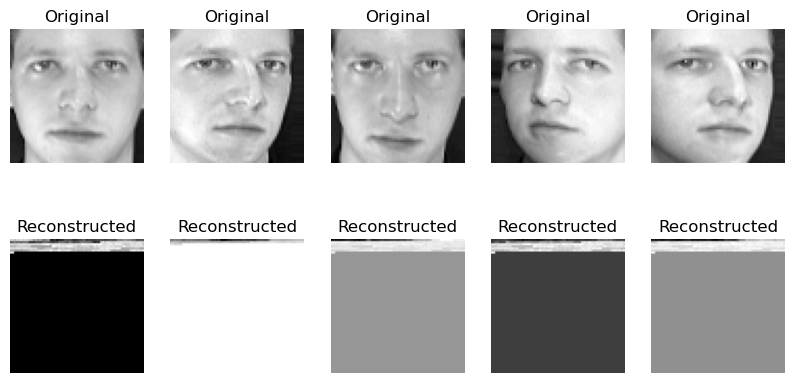

In [5]:
from sklearn.datasets import fetch_olivetti_faces

# Function: Load and preprocess Olivetti faces
def load_olivetti_faces():
    faces = fetch_olivetti_faces()
    X = faces.images.reshape(len(faces.images), -1)  # Flatten images
    return X, faces.images.shape[1], faces.images.shape[2]

# Load Olivetti faces
X, img_height, img_width = load_olivetti_faces()

# Dictionary Learning
n_components = 100  # Number of dictionary atoms
D = initialize_dictionary(X, n_components)
sparse_codes = omp(X, D, sparsity=10)
D, sparse_codes = k_svd(X, D, sparse_codes, n_iter=10)

# Reconstruct images
X_reconstructed = np.dot(sparse_codes, D.T)

# Display results
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i in range(5):
    axes[0, i].imshow(X[i].reshape(img_height, img_width), cmap="gray")
    axes[0, i].axis("off")
    axes[0, i].set_title("Original")

    axes[1, i].imshow(X_reconstructed[i].reshape(img_height, img_width), cmap="gray")
    axes[1, i].axis("off")
    axes[1, i].set_title("Reconstructed")

plt.show()
